# The Lenstra-Lenstra-Lovász (LLL) algorithm and its applications

This notebook provides an introduction to the Shortest Vector Problem (SVP) in lattices, the LLL algorithm and its application in number theory.

In [17]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import itertools
import sympy as sp
from scipy.linalg import qr
from fractions import Fraction
from fpylll import IntegerMatrix, LLL

## Lattice

A (full-rank) lattice $\Lambda$ in $\mathbb{R}^n$ is a subgroup of the additive group $\mathbb{R}^n$ of the form
$$ \Lambda = \left\{ \sum_{i=1}^n z_i \mathbf{b_i} \mid z_i \in \mathbb{Z} \right\} $$
where $\mathbf{B} = \left\{ \mathbf{b_1}, \ldots, \mathbf{b_n} \right\}$ is a basis of $\mathbb{R}^n$ (which is also the basis of the lattice).

A lattice can be visualized as a discrete grid in $\mathbb{R}^n$ formed by integer linear combinations of the basis vectors. The __fundamental region__ of the lattice is the parallelogram (in 2D) or parallelepiped (in 3D) spanned by the basis vectors.

The __determinant__ of the lattice, $\det(\Lambda)$, is the volume of the fundamental region of the lattice, given by $|\det(\mathbf{B})|$. The determinant is a measure of how "dense" the lattice is in space.

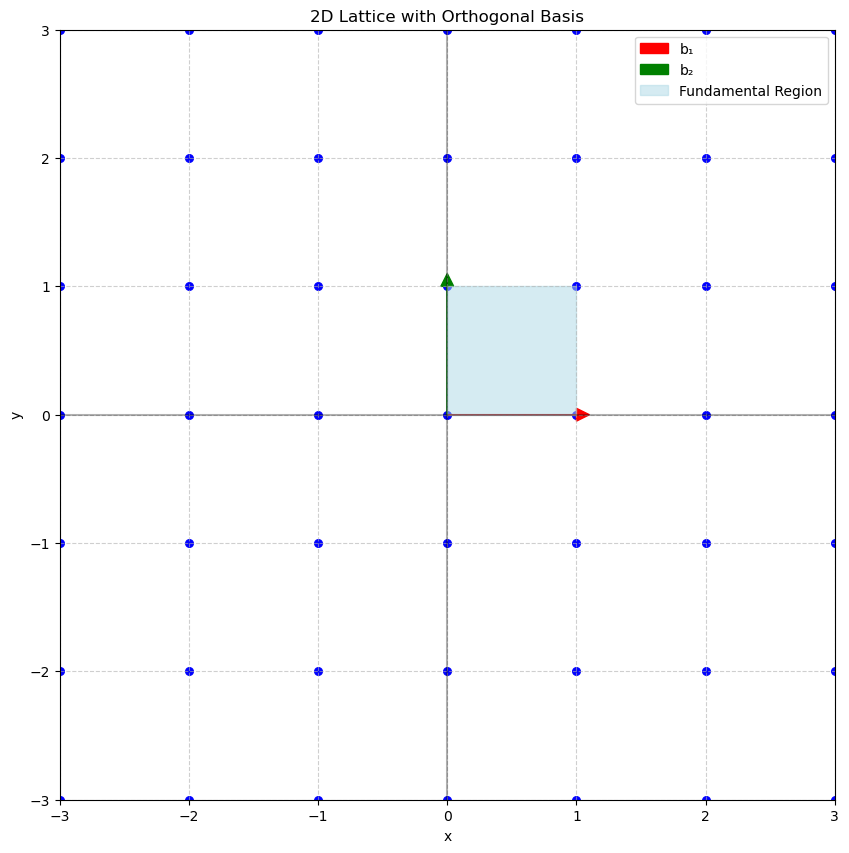

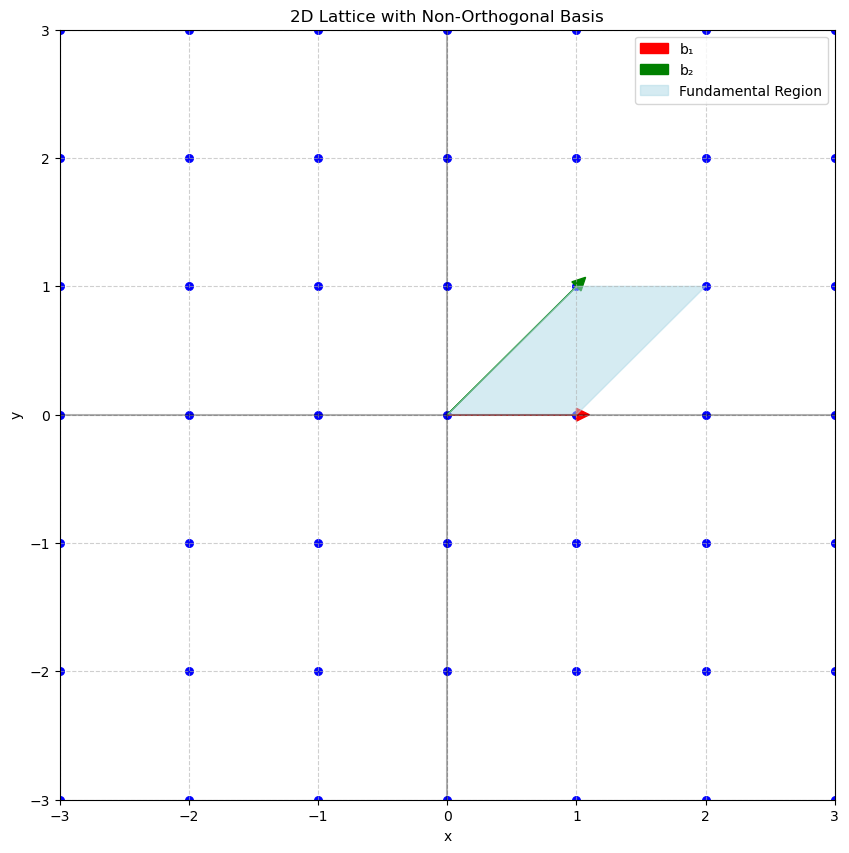

In [18]:
# Function to plot a 2D lattice
from sympy import li


def plot_2d_lattice(basis, limits=6, title="2D Lattice"):
    """Plot a 2D lattice with the given basis."""
    # Create a figure
    plt.figure(figsize=(10, 10))
    
    # Generate lattice points
    points = []
    for i in range(-limits, limits+1):
        for j in range(-limits, limits+1):
            point = i*basis[0] + j*basis[1]
            points.append(point)
    
    # Convert to numpy array for easier manipulation
    points = np.array(points)
    
    # Plot the lattice points
    plt.scatter(points[:, 0], points[:, 1], c='blue', s=30)
    
    # Plot the basis vectors
    plt.arrow(0, 0, basis[0][0], basis[0][1], head_width=0.1, head_length=0.1, fc='red', ec='red', label='b₁')
    plt.arrow(0, 0, basis[1][0], basis[1][1], head_width=0.1, head_length=0.1, fc='green', ec='green', label='b₂')
    
    # Add grid, labels, and title
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    plt.xlim(-3, 3)
    plt.ylim(-3, 3)

    # shade fundamental region of the lattice
    corners = np.array([
        [0, 0],
        basis[0],
        basis[0] + basis[1],
        basis[1]
    ])
    plt.fill(corners[:, 0], corners[:, 1], color='lightblue', alpha=0.5, label='Fundamental Region')

    # # Set equal aspect ratio
    # plt.axis('equal')
    plt.legend()
    plt.show()

# Example: Good basis
good_basis = np.array([[1, 0], [0, 1]])
plot_2d_lattice(good_basis, title="2D Lattice with Orthogonal Basis")

# Example: Bad basis
bad_basis = np.array([[1, 0], [1, 1]])
plot_2d_lattice(bad_basis, title="2D Lattice with Non-Orthogonal Basis")

# # Example: Very skewed basis
# skewed_basis = np.array([[1, 0], [20, 1]])
# plot_2d_lattice(skewed_basis, title="2D Lattice with Highly Skewed Basis")

## The Shortest Vector Problem (SVP)

SVP is expected to be NP-hard in general, but there are polynomial-time algorithms (such as the LLL algorithm) that can find _short_ vectors.

__Minkowski's theorem__ gives us a lower bound for the length of the shortest non-zero vector in an $n$-dimensional lattice:
$$ \lambda(\Lambda) \geq \sqrt{n} \cdot \det(\Lambda)^{1/n}, $$
where $\lambda(\Lambda)$ is the length of the shortest non-zero vector in the lattice.

Algorithms like the LLL algorithm rely on finding a __short and nearly orthogonal basis__ for a given lattice. If we cannot reduce a basis further, then the shortest basis vector is the solution to the SVP.

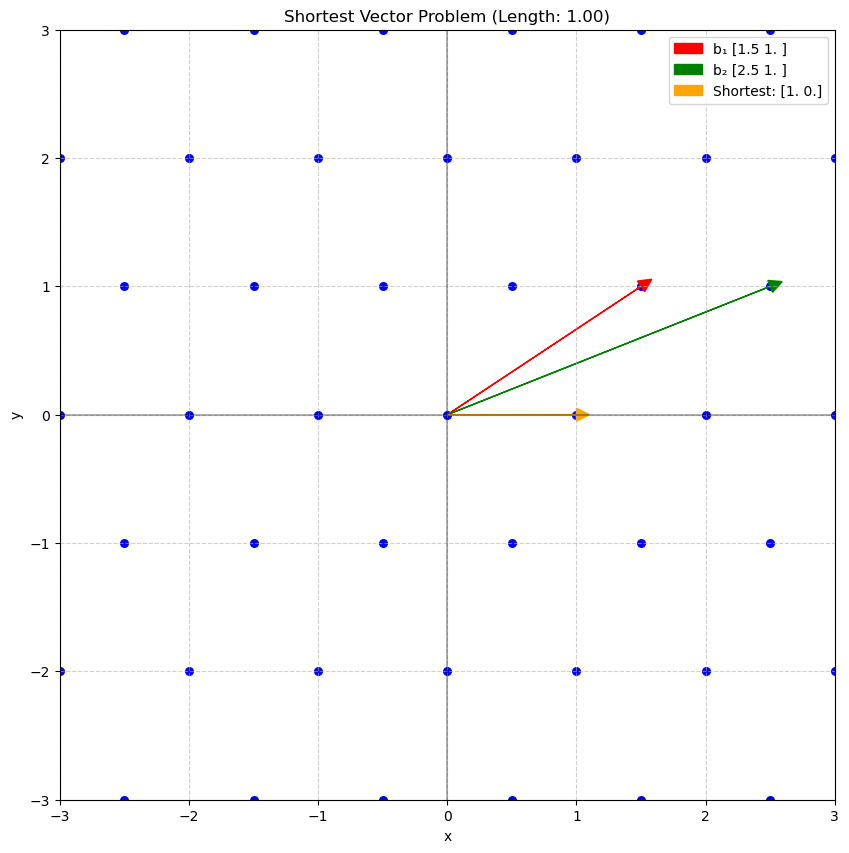

In [ ]:
# Visualise the shortest vector problem in 2D
def compute_vector_length(vector):
    """Compute the Euclidean length of a vector."""
    return np.sqrt(np.sum(vector**2))

def visualize_svp_2d(basis):
    """Visualize the shortest vector problem in 2D."""
    plt.figure(figsize=(10, 10))
    
    # Generate lattice points
    limits = 10
    points = []
    for i in range(-limits, limits+1):
        for j in range(-limits, limits+1):
            point = i*basis[0] + j*basis[1]
            points.append((point, i, j))
    
    # Find the shortest non-zero vector
    shortest_vector = None
    shortest_length = float('inf')
    
    for point, i, j in points:
        if i == 0 and j == 0:
            continue  # Skip the origin
        
        length = compute_vector_length(point)
        if length < shortest_length:
            shortest_length = length
            shortest_vector = point
    
    # Convert points to numpy array for plotting
    points_array = np.array([p[0] for p in points])
    
    # Plot the lattice points
    plt.scatter(points_array[:, 0], points_array[:, 1], c='blue', s=30)
    
    # Plot the basis vectors
    plt.arrow(0, 0, basis[0][0], basis[0][1], head_width=0.1, head_length=0.1, fc='red', ec='red', label=f'b₁ {basis[0]}')
    plt.arrow(0, 0, basis[1][0], basis[1][1], head_width=0.1, head_length=0.1, fc='green', ec='green', label=f'b₂ {basis[1]}')

    # Plot the shortest vector
    plt.arrow(0, 0, shortest_vector[0], shortest_vector[1], head_width=0.1, head_length=0.1, 
             fc='orange', ec='orange', label=f'Shortest: {shortest_vector}')
    
    # Add grid, labels, and title
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"Shortest Vector Problem (Length: {shortest_length:.2f})")
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.legend()
    
    # # Set equal aspect ratio
    # plt.axis('equal')
    plt.show()

# # Example with a skewed basis
# skewed_basis = np.array([[1, 0], [0.3, 0.5]])
# visualize_svp_2d(skewed_basis)

# Another example
another_basis = np.array([[1.5, 1], [2.5, 1]])
visualize_svp_2d(another_basis)

## Basis reduction

For a 2D lattice with basis $\mathbf{B} = \{ \mathbf{b}_1, \mathbf{b}_2 \}$, we have an algorithm due to Lagrange which finds the shortest vector efficiently:
1. If $||\mathbf{b}_1|| > ||\mathbf{b}_2||$, swap them.
2. Compute $q = \left\lfloor \frac{\mathbf{b_1} \cdot \mathbf{b_2}}{||\mathbf{b_1}||^2} \right\rceil$ and $\mathbf{r} = \mathbf{b_2} - q \cdot \mathbf{b_1}$. Set $\mathbf{b_2} = \mathbf{r}$.
3. If $||\mathbf{b_1}|| > ||\mathbf{b_2}||$, swap them again.
4. If $q = 0$, then $\mathbf{b_1}$ is the shortest vector. Otherwise, repeat from step 2.

To generalise this to higher dimensions, we need to adapt __Gram–Schmidt orthogonalization__. For a given basis $\mathbf{B} = \{ \mathbf{b_1}, \mathbf{b_2}, \ldots, \mathbf{b_m} \}$ of a subspace $H_m$ of $\mathbb{R}^n$, the standard Gram–Schmidt process produces the orthogonal basis $\mathbf{B}^* = \{ \mathbf{b_1}^*, \mathbf{b_2}^*, \ldots, \mathbf{b_m}^* \}$ as follows:
- $\mathbf{b_1}^* = \mathbf{b_1}$
- $\mathbf{b_2}^* = \mathbf{b_2} - u_{1,2} \mathbf{b_1}^*$ where $u_{1,2} = \frac{\mathbf{b_2} \cdot \mathbf{b_1}^*}{||\mathbf{b_1}^*||^2}$ \
  $\vdots$
- $\mathbf{b_m}^* = \mathbf{b_m} - \sum_{i < m} u_{i,m} \mathbf{b_i}^*$ where $u_{i,m} = \frac{\mathbf{b_m} \cdot \mathbf{b_i}^*}{||\mathbf{b_i}^*||^2}$

### The LLL algorithm

1. Perform Gram–Schmidt orthogonalization on the basis $\mathbf{B}$ to obtain $\mathbf{B}^*$, but with $\lfloor u_{i,m} \rceil$, which is
$$ u_{i,m} = \frac{\mathbf{b_m} \cdot \mathbf{b_i}^*}{||\mathbf{b_i}^*||^2} $$
rounded to the nearest integer.

2. For each $i$ to $n-1$, check whether:
$$ ||\mathbf{b_{i+1}}^*||^2 \geq \left( \frac{3}{4} - u_{i,i+1}^2 \right) ||\mathbf{b_i}^*||^2. $$
If false for any $i$, then swap $\mathbf{b_i}$ and $\mathbf{b_{i+1}}$ and go to step 1. If true for all $i$, then terminate and output $\mathbf{B}^*$.

For an LLL-reduced basis $\mathbf{B}^*$, we can show that:
$$ ||\mathbf{b_1}^*|| \leq 2^{(n-1)/2} \cdot \lambda(\Lambda) $$
where $\lambda(\Lambda)$ is the length of the shortest non-zero vector in the lattice.

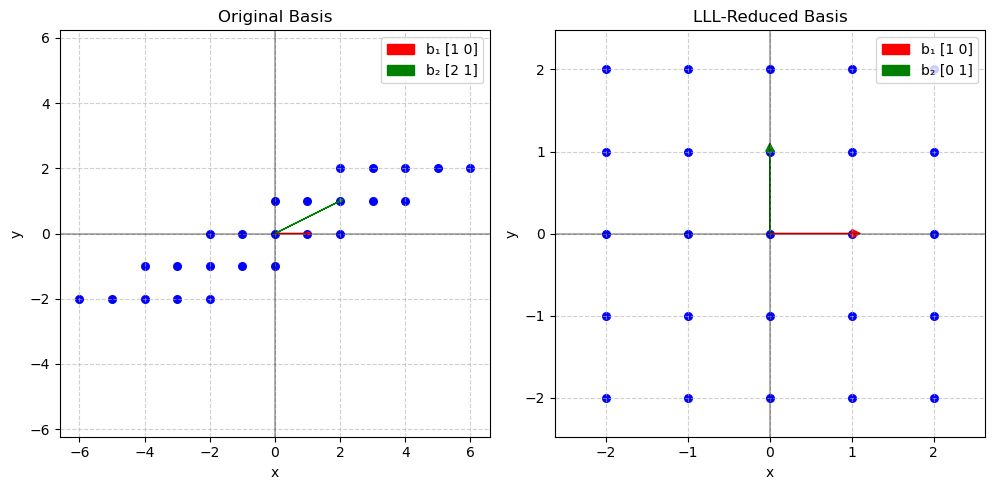

Original basis vector lengths:
  |b₁| = 1.0000
  |b₂| = 2.2361

Reduced basis vector lengths:
  |b₁*| = 1.0000
  |b₂*| = 1.0000

Orthogonality defect (closer to 1 is better):
  Original: 2.2361
  Reduced: 1.0000


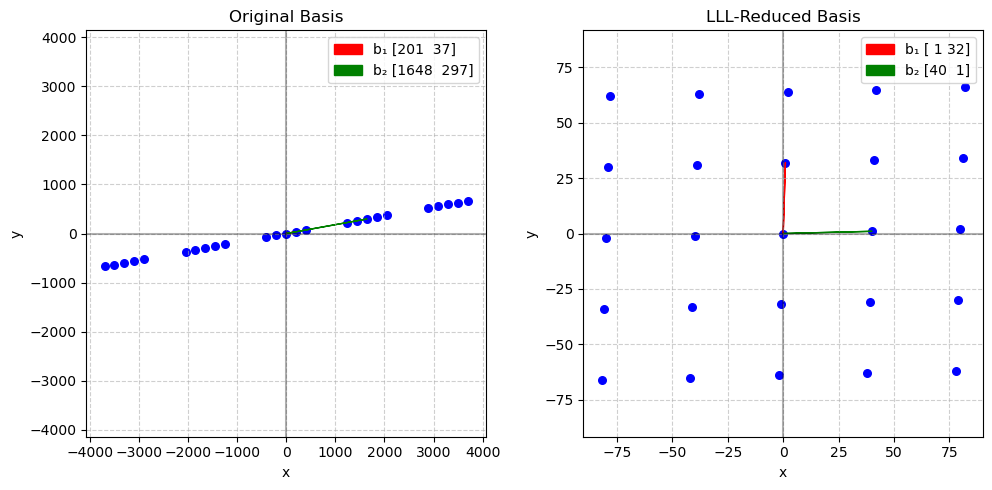

Original basis vector lengths:
  |b₁| = 204.3771
  |b₂| = 1674.5486

Reduced basis vector lengths:
  |b₁*| = 32.0156
  |b₂*| = 40.0125

Orthogonality defect (closer to 1 is better):
  Original: 267.5836
  Reduced: 1.0016


In [55]:
# Function to perform LLL reduction on a given basis
def lll_reduction(basis, delta=0.75):
    B_fpylll = IntegerMatrix.from_matrix(basis)
    LLL.reduction(B_fpylll, delta=delta)
    z = np.zeros_like(basis)
    _ = B_fpylll.to_matrix(z)
    return z

def visualize_lll_reduction(basis):
    """Visualize the LLL reduction process for a 2D basis."""
    # Perform LLL reduction
    reduced_basis = lll_reduction(basis)
    
    plt.figure(figsize=(15, 5))
    
    # Plot original basis and lattice
    plt.subplot(1, 3, 1)
    plot_2d_lattice_in_subplot(basis, limits=2, title="Original Basis")
    
    # Plot reduced basis and lattice
    plt.subplot(1, 3, 2)
    plot_2d_lattice_in_subplot(reduced_basis, limits=2, title="LLL-Reduced Basis")
    
    # # Plot comparison of basis vectors
    # plt.subplot(1, 3, 3)
    # plt.arrow(0, 0, basis[0][0], basis[0][1], head_width=0.1, head_length=0.1, 
    #          fc='red', ec='red', label=f'Original b₁ {basis[0]}')
    # plt.arrow(0, 0, basis[1][0], basis[1][1], head_width=0.1, head_length=0.1, 
    #          fc='green', ec='green', label=f'Original b₂ {basis[1]}')

    # plt.arrow(0, 0, reduced_basis[0][0], reduced_basis[0][1], head_width=0.1, head_length=0.1, 
    #          fc='orange', ec='orange', label=f'Reduced b₁ {reduced_basis[0]}')
    # plt.arrow(0, 0, reduced_basis[1][0], reduced_basis[1][1], head_width=0.1, head_length=0.1, 
    #          fc='purple', ec='purple', label=f'Reduced b₂ {reduced_basis[1]}')

    # plt.grid(True, linestyle='--', alpha=0.6)
    # plt.xlabel('x')
    # plt.ylabel('y')
    # plt.title("Basis Comparison")
    # plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    # plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    # plt.legend()
    # plt.axis('equal')
    
    plt.tight_layout()
    plt.show()
    
    # Print some information about the reduction
    print("Original basis vector lengths:")
    print(f"  |b₁| = {compute_vector_length(basis[0]):.4f}")
    print(f"  |b₂| = {compute_vector_length(basis[1]):.4f}")
    
    print("\nReduced basis vector lengths:")
    print(f"  |b₁*| = {compute_vector_length(reduced_basis[0]):.4f}")
    print(f"  |b₂*| = {compute_vector_length(reduced_basis[1]):.4f}")
    
    # Calculate orthogonality defect
    original_defect = (compute_vector_length(basis[0]) * compute_vector_length(basis[1])) / np.abs(np.linalg.det(basis))
    reduced_defect = (compute_vector_length(reduced_basis[0]) * compute_vector_length(reduced_basis[1])) / np.abs(np.linalg.det(reduced_basis))
    
    print("\nOrthogonality defect (closer to 1 is better):")
    print(f"  Original: {original_defect:.4f}")
    print(f"  Reduced: {reduced_defect:.4f}")

def plot_2d_lattice_in_subplot(basis, limits=3, title="2D Lattice"):
    """Plot a 2D lattice with the given basis in a subplot."""
    # Generate lattice points
    points = []
    for i in range(-limits, limits+1):
        for j in range(-limits, limits+1):
            point = i*basis[0] + j*basis[1]
            points.append(point)
    
    # Convert to numpy array for easier manipulation
    points = np.array(points)
    
    # Plot the lattice points
    plt.scatter(points[:, 0], points[:, 1], c='blue', s=30)
    
    # Plot the basis vectors
    plt.arrow(0, 0, basis[0][0], basis[0][1], head_width=0.1, head_length=0.1, fc='red', ec='red', label=f'b₁ {basis[0]}')
    plt.arrow(0, 0, basis[1][0], basis[1][1], head_width=0.1, head_length=0.1, fc='green', ec='green', label=f'b₂ {basis[1]}')

    # Add grid, labels, and title
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.legend()
    
    # Set equal aspect ratio
    plt.axis('equal')

# Example with a highly skewed basis
skewed_basis = np.array([[1, 0], [2, 1]])
visualize_lll_reduction(skewed_basis)

# Another example
another_basis = np.array([[201, 37], [1648, 297]])
visualize_lll_reduction(another_basis)

### Integer relations

The LLL algorithm can also be used to find __integer relations__ between real numbers. An integer relation between a set of real numbers $r_1, r_2, \ldots, r_n$ is a set of integers $z_1, z_2, \ldots, z_n$ such that:
$$ z_1 \cdot r_1 + z_2 \cdot r_2 + \ldots + z_n \cdot r_n = 0. $$

In the example below, we use the LLL algorithm to find the quadratic equation that the golden ratio satisfies. For the golden ratio $\phi = \frac{1 + \sqrt{5}}{2}$ to satisfy a quadratic equation, we need to find integers $a, b, c$ such that:
$$ a \cdot \phi^2 + b \cdot \phi + c = 0. $$
We can set up a lattice with the basis vectors formed by the powers of $\phi$:
$$[1, 0, 0, \lfloor scale \cdot \phi^2 \rfloor], \quad [0, 1, 0, \lfloor scale \cdot \phi \rfloor], \quad [0, 0, 1, scale],$$
where _scale_ is a large integer. The LLL algorithm will then find a short vector in the lattice which is a linear combination of these basis vectors and roughly looks like:
$$ [a, b, c, scale \cdot (a \cdot \phi^2 + b \cdot \phi + c)]. $$
Since the vector is short, the last component (unscaled) should be close to zero, allowing us to find the integer relation.

```python

In [53]:
# Example of using LLL to find an integer relation for a quadratic polynomial

# The (rounded) golden ratio
r = (1 + np.sqrt(5))/2
scale = 10000  # scaling factor for precision

# Construct the lattice basis as described
basis = np.array([
    [1, 0, 0, int(scale * r**2)],
    [0, 1, 0, int(scale * r)],
    [0, 0, 1, scale]
], dtype=int)

# Apply LLL reduction
B = IntegerMatrix.from_matrix(basis)
LLL.reduction(B)
reduced = np.zeros_like(basis)
_ = B.to_matrix(reduced)

# The first vector in the reduced basis gives the integer relation
coeffs = reduced[0, :3]
constant = reduced[0, 3] / scale

print("Golden ratio (r):", r)
print("LLL finds the shortest vector:", reduced[0])
print(f"Coefficients of the quadratic: a={coeffs[0]}, b={coeffs[1]}, c={coeffs[2]}")
print(f"Value of a*r^2 + b*r + c: {coeffs[0]*r**2 + coeffs[1]*r + coeffs[2]:.6e}")
print(f"Scaled constant term (should be close to zero): {constant:.6e}")

# The polynomial is a*x^2 + b*x + c = 0
print(f"\nThe polynomial is: {coeffs[0]}*x^2 + ({coeffs[1]})*x + ({coeffs[2]}) = 0")

Golden ratio (r): 1.618033988749895
LLL finds the shortest vector: [-1  1  1  0]
Coefficients of the quadratic: a=-1, b=1, c=1
Value of a*r^2 + b*r + c: 0.000000e+00
Scaled constant term (should be close to zero): 0.000000e+00

The polynomial is: -1*x^2 + (1)*x + (1) = 0


## Mertens conjecture

Möbius function $\mu(n)$ is defined as:
$$ \mu(n) = \begin{cases}
1 & \text{if } n = 1, \\
0 & \text{if } n \text{ has a squared prime factor,} \\
-1 & \text{if } n \text{ is a product of an odd number of distinct primes,} \\
1 & \text{if } n \text{ is a product of an even number of distinct primes.}
\end{cases}$$

Mertens' function $M(x)$ is defined as the summatory function of the Möbius function:
$$ M(x) = \sum_{n \leq x} \mu(n). $$

Mertens' conjecture states that:
$$ |M(x)| \le \sqrt{x}. $$

The reason why Mertens' conjecture is important is that it __implies the Riemann Hypothesis__, which is one of the most important unsolved problems in mathematics. Unfortunately, Mertens' conjecture is false and was disproved in 1985 by Andrew Odlyzko and Herman te Riele using the LLL algorithm. 

Despite being disproven, there is no explicit counterexample and the upper bound on the counterexample is so large that there is no hope of finding it with current computational resources. Therefore, it is an ongoing area of research to find better bounds on the counterexample.

### Connection with integer relations

Skipping a textbook worth of details, the problem boils down to finding a $y$ such that:
$$ \sum_{j=1}^{n} \alpha_j^2 \cos(\gamma_j y - \psi_j - 2\pi m_j) $$
is large, where $\alpha_j, \gamma_j, \psi_j$ are real numbers that come from the Riemann zeta-function and $m_j$ are integers. Using the approximation $\cos(\theta) \approx 1 - \frac{\theta^2}{2}$ for small $\theta$, this can be reformulated as an attempt to make the following sum small:
$$ \sum_{j=1}^n \alpha_j^2 (\gamma_j y - \psi_j - 2 \pi m_j)^2. $$

This is similar to the idea behind the integer relation problem above and hence, one can conceivably apply lattice reduction to look for an appropriate $y$ (and $m_j$'s).

